In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
mpl.rc('axes', labelsize=16)
mpl.rc('axes', titlesize=18)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('legend', fontsize=14)
mpl.rc('legend', title_fontsize=16)
%matplotlib inline

from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn_pandas import DataFrameMapper

from scipy.stats import percentileofscore

# Titanic - Machine Learning from Disaster
This is the legendary Titanic ML competition on [Kaggle](https://www.kaggle.com/c/titanic)

## Goal
To predict if a passanger survived the sinking of the Titanic or not.

## Crrent Solutions
There are dosens of solutions available on the [discussion forum](https://www.kaggle.com/c/titanic/discussion) and on the Internet.

## Frame the Problem
- Supervised learning
- Classification
- Binary classification (survived of not)
- Batch learning (no continuous flow of data and the dataset is small)

## Performance metrics
**The percentage of correctly predicted passengers** (accuracy).

There are also several useful metrics for evaluating the performance of a classification system:
- precision,
- recall,
- $F_1$ score,
- precision/recall curve,
- ROC curve,
- ROC AUC score.

## Target performance
The leaderboard of this competition contains almost 14000 entries. 
The median score is about 0.775, but less than 3% of the solutions have a score above 0.8. 
Thus, **an accuracy score equal to or greater than 0.8 would be a very good result**.

In [2]:
leaderboard = pd.read_csv('../datasets/titanic-publicleaderboard.csv')
leaderboard.head()

,TeamId,TeamName,SubmissionDate,Score
0,6987444,no name,2022-08-23 18:16:28,1.0
1,720238,rosh,2022-06-26 10:58:42,1.0
2,8814675,nikolai otvetchikov #2,2022-06-26 13:59:39,1.0
3,8821160,Vibhav Rathkanthiwar,2022-06-26 15:28:12,1.0
4,6590016,Osman Altuntas,2022-07-24 15:40:15,1.0


In [3]:
leaderboard.Score.describe()

count    13915.000000
mean         0.760751
std          0.075145
min          0.000000
25%          0.765550
50%          0.775110
75%          0.777510
max          1.000000
Name: Score, dtype: float64

In [4]:
percentileofscore(leaderboard.Score, 0.8) / 100

0.9711821775062881

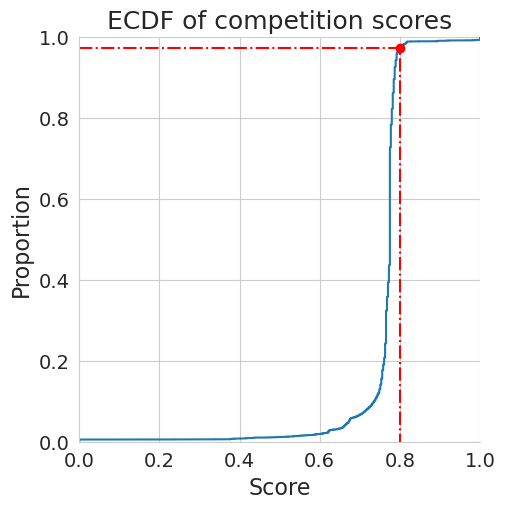

In [5]:
def plot_ecdf_with_target(data, target):
    sns.displot(data, stat='proportion', kind='ecdf', height=5, aspect=1)
    
    quantile = percentileofscore(data, target) / 100
    
    plt.plot([0, target, target], [quantile, quantile, 0], '-.r')
    plt.plot([target], [quantile], 'or')
    
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    
    plt.title('ECDF of competition scores')
    
    plt.show()

    
plot_ecdf_with_target(leaderboard.Score, 0.8)

In addition, there are several solutions with a score equal to 1.0. Have authors reached perfection?

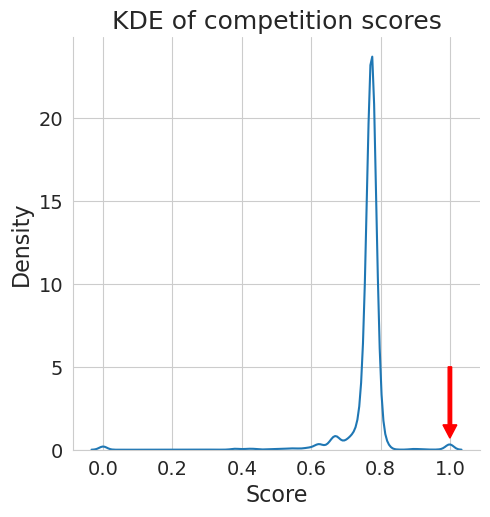

In [6]:
sns.displot(leaderboard, x='Score', kind='kde')
plt.arrow(x=1.0, y=5, dx=0, dy=-3.5, width=0.01, head_width=0.04, head_length=0.8, color='r')
plt.title("KDE of competition scores")

plt.show()

## Data Dictionary
0. **PassengerId** - Passenger ID.
1. **Survived** - Survival:
    - 0 = No, 
    - 1 = Yes.
2. **Pclass** - Ticket class:
    - 1 = 1st, 
    - 2 = 2nd, 
    - 3 = 3rd.
3. **Name** - Passanger's name, for example, "Braund, Mr. Owen Harris".
4. **Sex** - Gender:
    - male,
    - female.
5. **Age** - Age in years, for example 38.0.
6. **SibSp** - Number of siblings or spouses aboard the Titanic.
7. **Parch** - Number of parents or children aboard the Titanic.
8. **Ticket** - Ticket number, for example, A/5 21171.
9. **Fare** - Passenger fare, for ecample, 71.2833.
10. **Cabin** - Cabin number, for example, C85.
11. **Embarked** - Port of Embarkation:
    - C = Cherbourg,
    - Q = Queenstown,
    - S = Southampton.
    
### Features
PassengerId, Pclass, Name, Sex, Age, SibSp, Parch, Ticket,
Fare, Cabin, Embarked

### Target
Survived
    
## Variable Notes
- **pclass**: socio-economic status
    - *1st* = Upper
    - *2nd* = Middle
    - *3rd* = Lower
- **age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
- **sibsp**: number of sibling/spouses aboard the Titanic
    - *sibling* = brother, sister, stepbrother, stepsister
    - *spouse* = husband, wife (mistresses and fiancés were ignored)
- **parch**: number of parents (mother, father)/children (daughter, son, stepdauter, stepson) aboard the Titanic. Some children travelled only with a nanny, therefore parch=0 for them.

## File Paths
- **training set**: ../datasets/train.csv
- **test set**: ../datasets/test.csv
- **example of a submission file**: ../datasets/gender_submission.csv

## Assumptions
Women were more likely to survive than men.

## Load Data
### Traing data

In [7]:
data = pd.read_csv('../datasets/train.csv')

### Test set for submission

In [8]:
submission_X = pd.read_csv('../datasets/gender_submission.csv')

## Preliminary Analysis
### Shape of the dataset

In [9]:
data.shape

(891, 12)

### First rows of the dataset

In [10]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data types and non-null counts

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Number of missing values

In [12]:
data.isna().sum(axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Number of unique values
There are high-cardinality features with object dtype:
- Name
- Ticket
- Cabin

This features, possibly, will need special preprocessing.

The **"PassengerId"** feature is the ID of the passanger. 
It won't help in analysis and will be droped.

In [13]:
data.select_dtypes(include='object').nunique()

Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
dtype: int64

In [14]:
data.select_dtypes(exclude='object').nunique()

PassengerId    891
Survived         2
Pclass           3
Age             88
SibSp            7
Parch            7
Fare           248
dtype: int64

### Summary statistics

In [15]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [16]:
data.select_dtypes(include='object').describe()

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


## Sample a Test Set

The test set will be used to evaluate performance of a very final model
and forecast the score in the competitions leaderboard. It may seems like
it's to early to create a test set, but I'll do it to prevent data snooping.

I'm going to do stratified sampling with scikit-learn's StratifiedShuffleSplit to maintain equal ratio of men and women in the train set and the test set. Women seem to have had a better chance of surviving due to the "women and children first" protocol for loading lifeboats.

First, let's check how many passengers survived.

Number of survived passengers 342, (38.38%)
Number of drowned passengers 549, (61.62%)


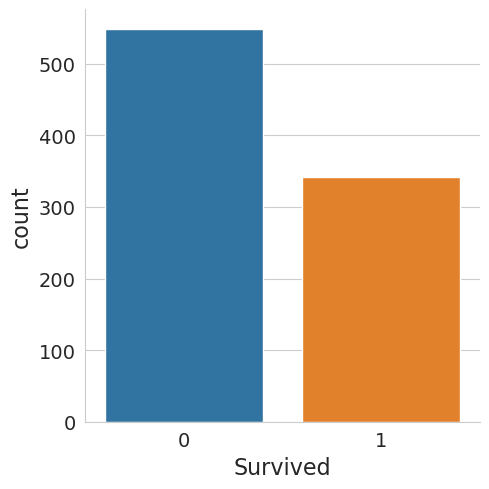

In [17]:
print(f'Number of survived passengers {data.Survived.sum()}, ({data.Survived.sum()/len(data):.2%})')
print(f'Number of drowned passengers {len(data) - data.Survived.sum()}, ({(len(data) - data.Survived.sum())/len(data):.2%})')
sns.catplot(data=data, x='Survived', kind='count')
# plt.savefig('../docs/images/number_of_survivors.pdf', bbox_inches='tight')
plt.show()

Next, let's check the proportion of women among the survivors.

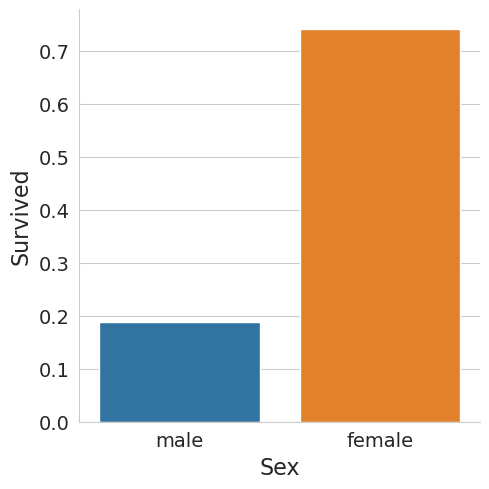

In [18]:
sns.catplot(data=data, x='Sex', y='Survived', kind='bar', errorbar=None)
# plt.savefig('../docs/images/proportion_of_survived_women.pdf', bbox_inches='tight')
plt.show()

Let's check this assumption  for each passanger class.

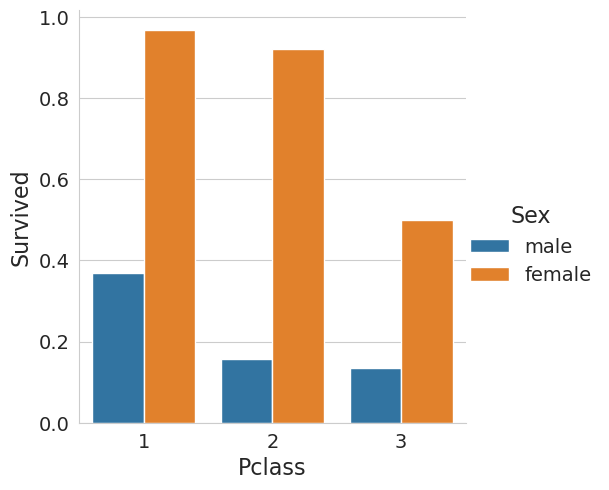

In [19]:
sns.catplot(data=data, x='Pclass', y='Survived', hue='Sex', kind='bar', errorbar=None)
# plt.savefig('../docs/images/proportion_of_survived_women_among_pclasses.pdf',
#             bbox_inches='tight')
plt.show()

The assumtpion seems to be correct. Now, it's time to split dataset.

In [20]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(data, data.Sex):
    train_set = data.loc[train_index]
    test_set = data.loc[test_index]

## Exploratory Analysis
Let's explore each attribute and its characteristics.

In [21]:
exploratory_set = train_set.copy()

for column_name in exploratory_set:
    print(column_name)

PassengerId
Survived
Pclass
Name
Sex
Age
SibSp
Parch
Ticket
Fare
Cabin
Embarked


### Pclass

In [22]:
exploratory_set.Pclass = exploratory_set.Pclass.astype('category')

In [23]:
exploratory_set.Pclass.head()

788    3
347    3
629    3
734    2
106    3
Name: Pclass, dtype: category
Categories (3, int64): [1, 2, 3]

In [24]:
exploratory_set.Pclass.info()

<class 'pandas.core.series.Series'>
Int64Index: 712 entries, 788 to 261
Series name: Pclass
Non-Null Count  Dtype   
--------------  -----   
712 non-null    category
dtypes: category(1)
memory usage: 6.4 KB


In [25]:
exploratory_set.Pclass.describe()

count     712
unique      3
top         3
freq      402
Name: Pclass, dtype: int64

In [26]:
exploratory_set.Pclass.value_counts()

3    402
1    172
2    138
Name: Pclass, dtype: int64

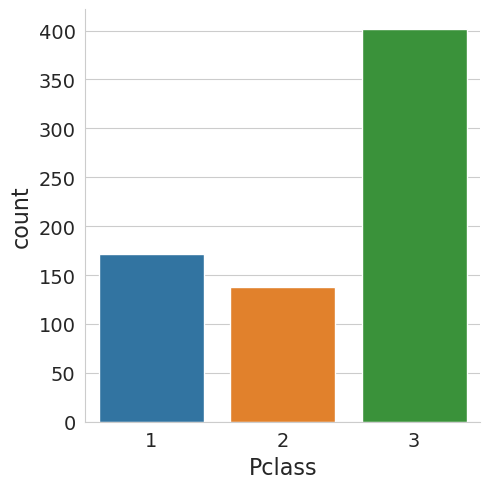

In [27]:
sns.catplot(data=exploratory_set, x='Pclass', kind='count')
# plt.savefig('../docs/images/pclass_count.pdf', bbox_inches='tight')
plt.show()

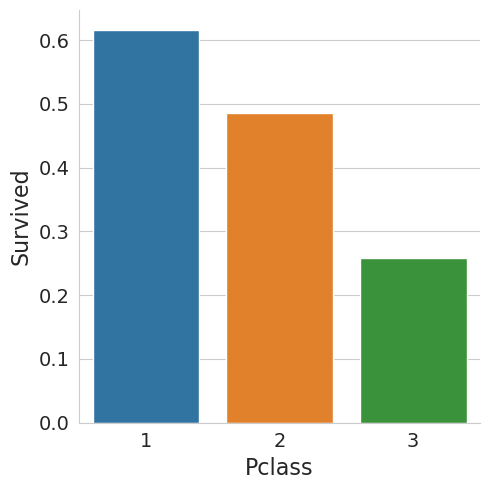

In [28]:
sns.catplot(data=exploratory_set, x='Pclass', y='Survived', kind='bar', errorbar=None)
# plt.savefig('../docs/images/pclass_survived_entire_dataset.pdf', bbox_inches='tight')
plt.show()

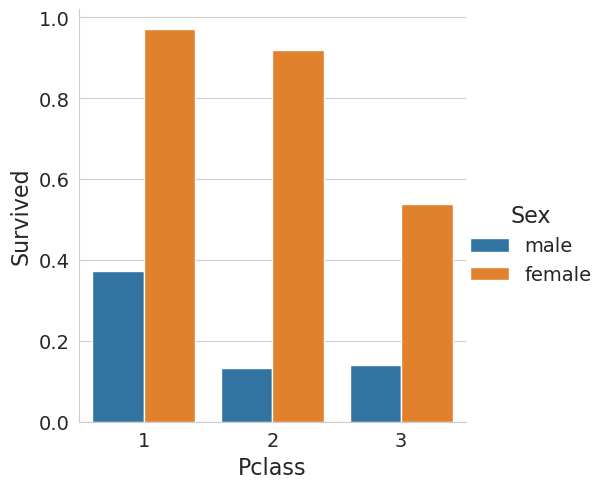

In [29]:
sns.catplot(data=exploratory_set, x='Pclass', y='Survived', hue='Sex', kind='bar', errorbar=None)
# plt.savefig('../docs/images/pclass_survived_gender.pdf', bbox_inches='tight')
plt.show()

### Name

In [30]:
exploratory_set.Name.head()

788                   Dean, Master. Bertram Vere
347    Davison, Mrs. Thomas Henry (Mary E Finck)
629                     O'Connell, Mr. Patrick D
734                 Troupiansky, Mr. Moses Aaron
106             Salkjelsvik, Miss. Anna Kristine
Name: Name, dtype: object

In [31]:
exploratory_set.Name.info()

<class 'pandas.core.series.Series'>
Int64Index: 712 entries, 788 to 261
Series name: Name
Non-Null Count  Dtype 
--------------  ----- 
712 non-null    object
dtypes: object(1)
memory usage: 11.1+ KB


In [32]:
exploratory_set.Name.describe()

count                            712
unique                           712
top       Dean, Master. Bertram Vere
freq                               1
Name: Name, dtype: object

In [33]:
exploratory_set['Title'] = exploratory_set.Name.str.extract(pat=r'\b,\s(.+)\.\s[\b(]?', expand=True)
exploratory_set['Title'] = exploratory_set['Title'].str.lower()
exploratory_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
788,789,1,3,"Dean, Master. Bertram Vere",male,1.0,1,2,C.A. 2315,20.5750,NaN,S,master
347,348,1,3,"Davison, Mrs. Thomas Henry (Mary E Finck)",female,NaN,1,0,386525,16.1000,NaN,S,mrs
629,630,0,3,"O'Connell, Mr. Patrick D",male,NaN,0,0,334912,7.7333,NaN,Q,mr
734,735,0,2,"Troupiansky, Mr. Moses Aaron",male,23.0,0,0,233639,13.0000,NaN,S,mr
106,107,1,3,"Salkjelsvik, Miss. Anna Kristine",female,21.0,0,0,343120,7.6500,NaN,S,miss


In [34]:
exploratory_set.Title.head()

788    master
347       mrs
629        mr
734        mr
106      miss
Name: Title, dtype: object

In [35]:
exploratory_set.Title.describe()

count     712
unique     17
top        mr
freq      415
Name: Title, dtype: object

In [36]:
exploratory_set['Title'].value_counts(dropna=False)

mr              415
miss            145
mrs             100
master           29
dr                6
rev               4
col               2
major             2
jonkheer          1
lady              1
ms                1
the countess      1
don               1
mme               1
sir               1
capt              1
mlle              1
Name: Title, dtype: int64

In [37]:
exploratory_set.Title.isna().any()

False

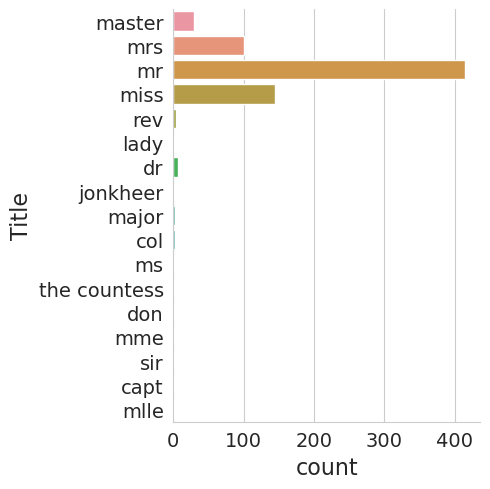

In [38]:
sns.catplot(data=exploratory_set, y='Title', kind='count')
# plt.savefig('../docs/images/title_count.pdf', bbox_inches='tight')
plt.show()

In [39]:
aristocratic_titles = ['rev', 'lady', 'dr', 'jonkheer', 'major', 'col', 
                       'ms', 'the countess', 'don', 'mme', 'sir', 'capt', 'mlle']
exploratory_set[exploratory_set.Title.isin(aristocratic_titles)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
149,150,0,2,"Byles, Rev. Thomas Roussel Davids",male,42.0,0,0,244310,13.0000,NaN,S,rev
556,557,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,48.0,1,0,11755,39.6000,A16,C,lady
317,318,0,2,"Moraweck, Dr. Ernest",male,54.0,0,0,29011,14.0000,NaN,S,dr
848,849,0,2,"Harper, Rev. John",male,28.0,0,1,248727,33.0000,NaN,S,rev
660,661,1,1,"Frauenthal, Dr. Henry William",male,50.0,2,0,PC 17611,133.6500,NaN,S,dr
822,823,0,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.0000,NaN,S,jonkheer
766,767,0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6000,NaN,C,dr
449,450,1,1,"Peuchen, Major. Arthur Godfrey",male,52.0,0,0,113786,30.5000,C104,S,major
536,537,0,1,"Butt, Major. Archibald Willingham",male,45.0,0,0,113050,26.5500,B38,S,major
249,250,0,2,"Carter, Rev. Ernest Courtenay",male,54.0,1,0,244252,26.0000,NaN,S,rev


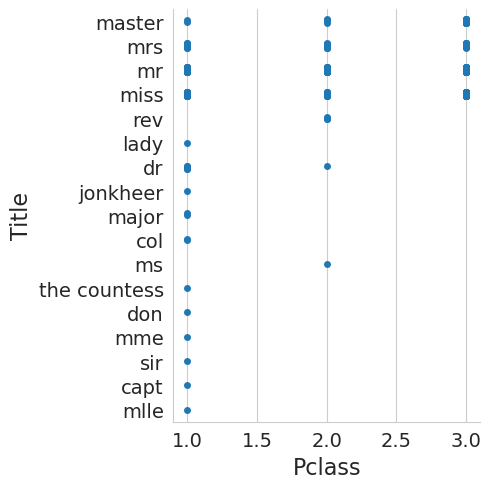

In [40]:
sns.catplot(data=exploratory_set, y='Title', x='Pclass', orient='h')
# plt.savefig('../docs/images/title_belonging_to_class.pdf', bbox_inches='tight')
plt.show()

In [41]:
exploratory_set.loc[exploratory_set.Title.isin(aristocratic_titles), 'Title'] = 'aristocratic'

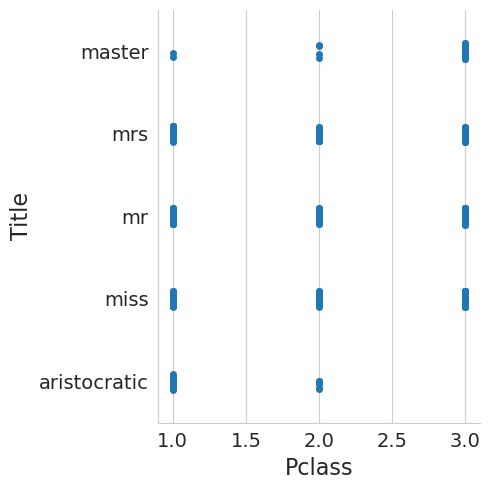

In [42]:
sns.catplot(data=exploratory_set, y='Title', x='Pclass', orient='h')
# plt.savefig('../docs/images/generalized_title_belonging_to_class.pdf', bbox_inches='tight')
plt.show()

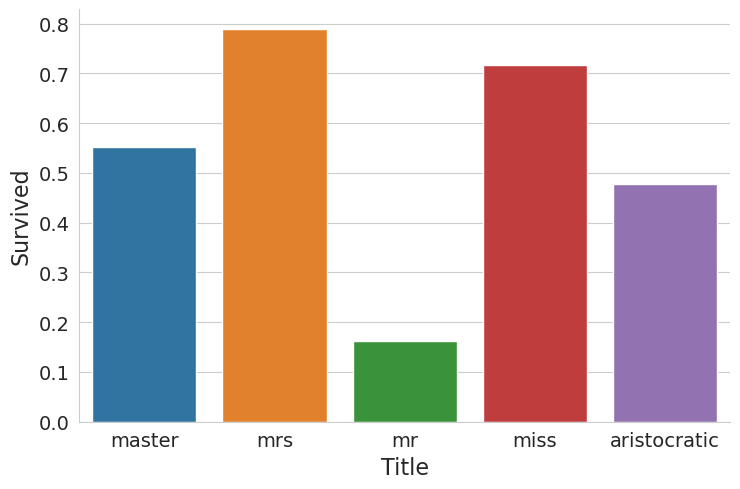

In [43]:
sns.catplot(data=exploratory_set, x='Title', y='Survived', kind='bar', errorbar=None, aspect=1.5)
# plt.savefig('../docs/images/title_survival.pdf', bbox_inches='tight')
plt.show()

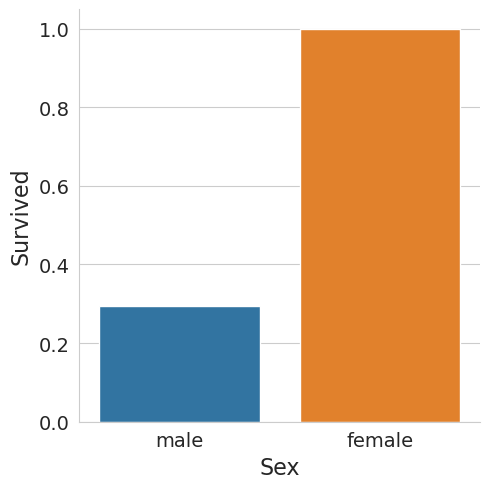

In [44]:
sns.catplot(data=exploratory_set[exploratory_set.Title=='aristocratic'], x='Sex', y='Survived', kind='bar', errorbar=None)
# plt.savefig('../docs/images/aristocratic_gender_survival.pdf', bbox_inches='tight')
plt.show()

### Sex

We have already studied this attribute in chapter "Sample a Test Set" and
have shown that in the entire dataset and in each **"Pclass"** there are 
more female survivors than males. So, it's very important attribute, and 
I will consider other attributes separetely for each gender.

In [45]:
exploratory_set.Sex.head()

788      male
347    female
629      male
734      male
106    female
Name: Sex, dtype: object

In [46]:
exploratory_set.Sex.info()

<class 'pandas.core.series.Series'>
Int64Index: 712 entries, 788 to 261
Series name: Sex
Non-Null Count  Dtype 
--------------  ----- 
712 non-null    object
dtypes: object(1)
memory usage: 11.1+ KB


In [47]:
exploratory_set.Sex.describe()

count      712
unique       2
top       male
freq       461
Name: Sex, dtype: object

In [48]:
exploratory_set.Sex.value_counts(dropna=False)

male      461
female    251
Name: Sex, dtype: int64

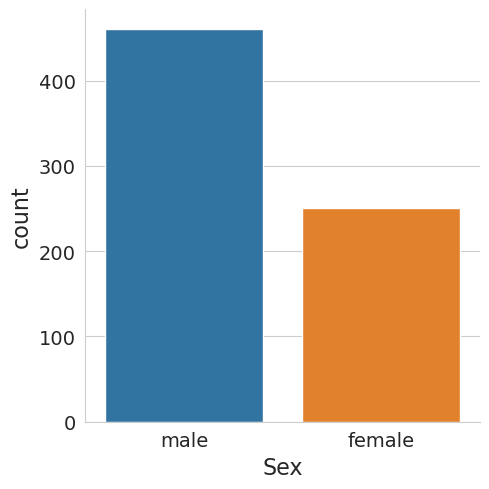

In [49]:
sns.catplot(data=exploratory_set, x='Sex', kind='count')
# plt.savefig('../docs/images/number_of_men_and_women.pdf', bbox_inches='tight')
plt.show()

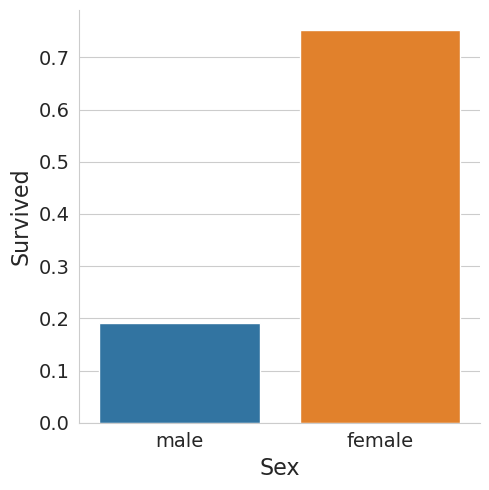

In [50]:
sns.catplot(data=exploratory_set, x='Sex', y='Survived', kind='bar', errorbar=None)
# plt.savefig('../docs/images/survial_rate_of_men_and_women.pdf', bbox_inches='tight')
plt.show()

### Age

In [51]:
exploratory_set.Age.head()

788     1.0
347     NaN
629     NaN
734    23.0
106    21.0
Name: Age, dtype: float64

In [52]:
exploratory_set.Age.info()

<class 'pandas.core.series.Series'>
Int64Index: 712 entries, 788 to 261
Series name: Age
Non-Null Count  Dtype  
--------------  -----  
578 non-null    float64
dtypes: float64(1)
memory usage: 11.1 KB


In [53]:
exploratory_set.Age.describe()

count    578.000000
mean      29.781436
std       14.628503
min        0.420000
25%       21.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [54]:
exploratory_set.Age.isna().sum()

134

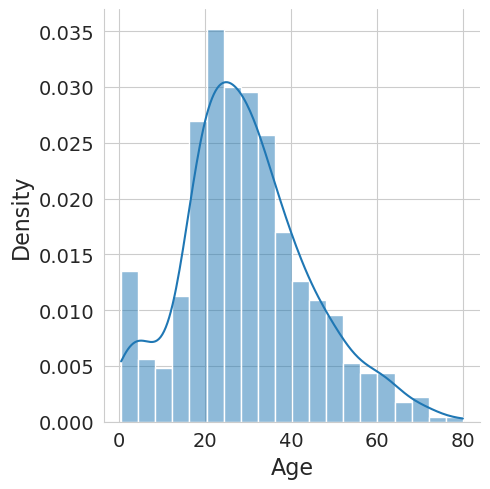

In [55]:
sns.displot(exploratory_set.Age, stat='density', kde=True)
# plt.savefig('../docs/images/age_distribution.pdf', bbox_inches='tight')
plt.show()

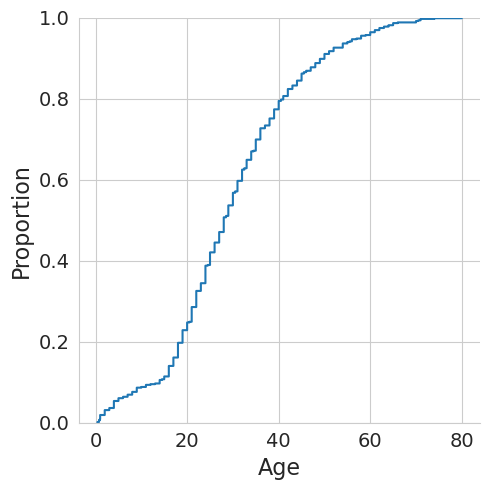

In [56]:
sns.displot(exploratory_set.Age, kind='ecdf')
# plt.savefig('../docs/images/age_ecdf.pdf', bbox_inches='tight')
plt.show()

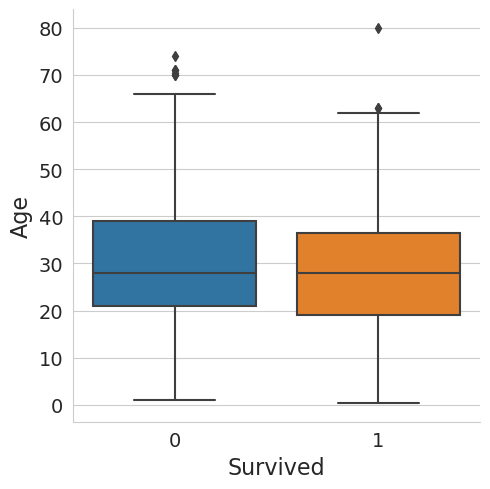

In [57]:
sns.catplot(data=exploratory_set, x='Survived', y='Age', kind='box')
# plt.savefig('../docs/images/age_by_survived_cat.pdf', bbox_inches='tight')
plt.show()

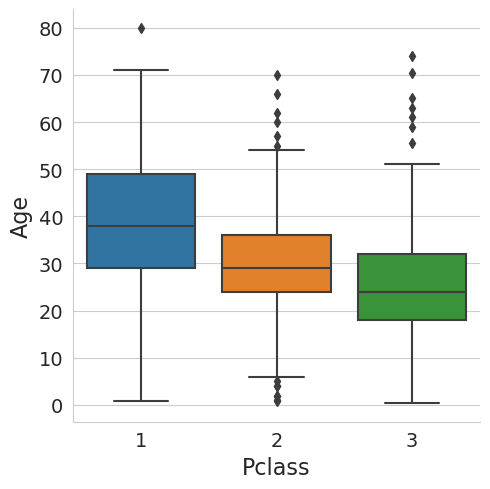

In [58]:
sns.catplot(data=exploratory_set, x='Pclass', y='Age', kind='box')
# plt.savefig('../docs/images/age_by_pclass_cat.pdf', bbox_inches='tight')
plt.show()

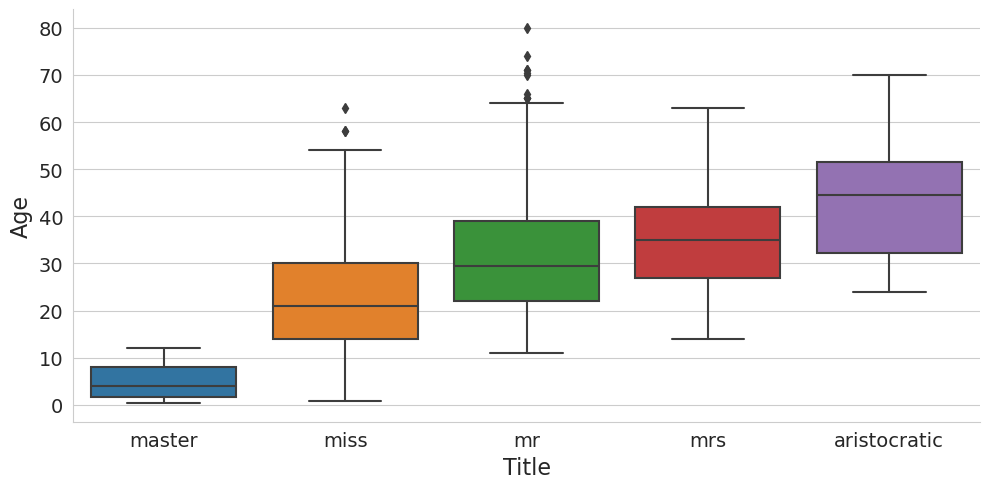

In [59]:
sns.catplot(data=exploratory_set.sort_values('Age'), x='Title', y='Age', kind='box', aspect=2)
# plt.savefig('../docs/images/age_by_title_cat.pdf', bbox_inches='tight')
plt.show()

### SibSp

In [60]:
exploratory_set.SibSp.head()

788    1
347    1
629    0
734    0
106    0
Name: SibSp, dtype: int64

In [61]:
exploratory_set.SibSp.info()

<class 'pandas.core.series.Series'>
Int64Index: 712 entries, 788 to 261
Series name: SibSp
Non-Null Count  Dtype
--------------  -----
712 non-null    int64
dtypes: int64(1)
memory usage: 11.1 KB


In [62]:
exploratory_set.SibSp.describe()

count    712.000000
mean       0.546348
std        1.110283
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64

In [63]:
exploratory_set.SibSp.value_counts(dropna=False)

0    477
1    171
2     25
4     16
3     13
8      5
5      5
Name: SibSp, dtype: int64

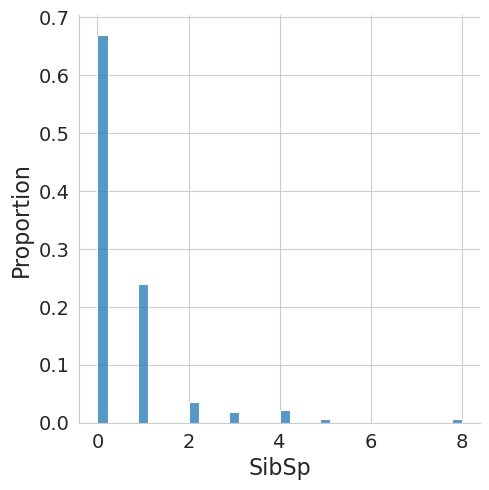

In [64]:
sns.displot(exploratory_set.SibSp, stat='proportion', kde=False)
# plt.savefig('../docs/images/sibsp_distribution.pdf', bbox_inches='tight')
plt.show()

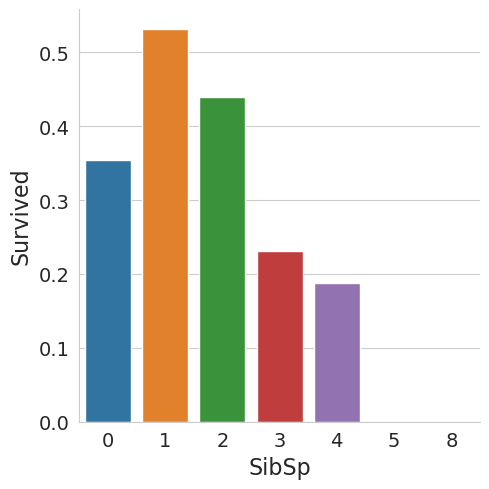

In [65]:
sns.catplot(data=exploratory_set, x='SibSp', y='Survived', kind='bar', errorbar=None)
# plt.savefig('../docs/images/sibsp_survival_rate.pdf', bbox_inches='tight')
plt.show()

### Parch

In [66]:
exploratory_set.Parch.head()

788    2
347    0
629    0
734    0
106    0
Name: Parch, dtype: int64

In [67]:
exploratory_set.Parch.info()

<class 'pandas.core.series.Series'>
Int64Index: 712 entries, 788 to 261
Series name: Parch
Non-Null Count  Dtype
--------------  -----
712 non-null    int64
dtypes: int64(1)
memory usage: 11.1 KB


In [68]:
exploratory_set.Parch.describe()

count    712.000000
mean       0.373596
std        0.803144
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64

In [69]:
exploratory_set.Parch.value_counts(dropna=False)

0    543
1     99
2     58
5      4
4      4
3      3
6      1
Name: Parch, dtype: int64

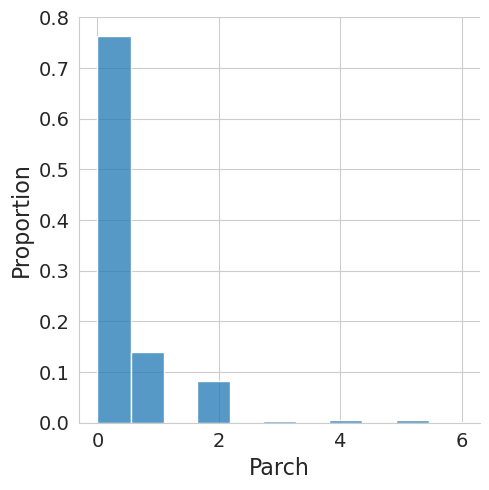

In [70]:
sns.displot(exploratory_set.Parch, stat='proportion', kde=False)
# plt.savefig('../docs/images/parch_distribution.pdf', bbox_inches='tight')
plt.show()

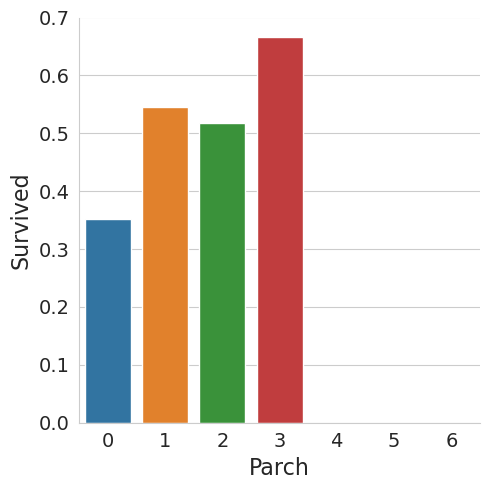

In [71]:
sns.catplot(data=exploratory_set, x='Parch', y='Survived', kind='bar', errorbar=None)
# plt.savefig('../docs/images/parch_survival_rate.pdf', bbox_inches='tight')
plt.show()

### Ticket

In [72]:
exploratory_set.Ticket.head()

788    C.A. 2315
347       386525
629       334912
734       233639
106       343120
Name: Ticket, dtype: object

In [73]:
exploratory_set.Ticket.info()

<class 'pandas.core.series.Series'>
Int64Index: 712 entries, 788 to 261
Series name: Ticket
Non-Null Count  Dtype 
--------------  ----- 
712 non-null    object
dtypes: object(1)
memory usage: 11.1+ KB


In [74]:
exploratory_set.Ticket.describe()

count      712
unique     566
top       1601
freq         7
Name: Ticket, dtype: object

In [75]:
exploratory_set.Ticket.isna().sum()

0

### Fare

In [76]:
exploratory_set.Fare.head()

788    20.5750
347    16.1000
629     7.7333
734    13.0000
106     7.6500
Name: Fare, dtype: float64

In [77]:
exploratory_set.Fare.info()

<class 'pandas.core.series.Series'>
Int64Index: 712 entries, 788 to 261
Series name: Fare
Non-Null Count  Dtype  
--------------  -----  
712 non-null    float64
dtypes: float64(1)
memory usage: 11.1 KB


In [78]:
exploratory_set.Fare.describe()

count    712.000000
mean      31.282893
std       44.377233
min        0.000000
25%        7.895800
50%       14.456250
75%       31.275000
max      512.329200
Name: Fare, dtype: float64

In [79]:
exploratory_set.Fare.isna().sum()

0

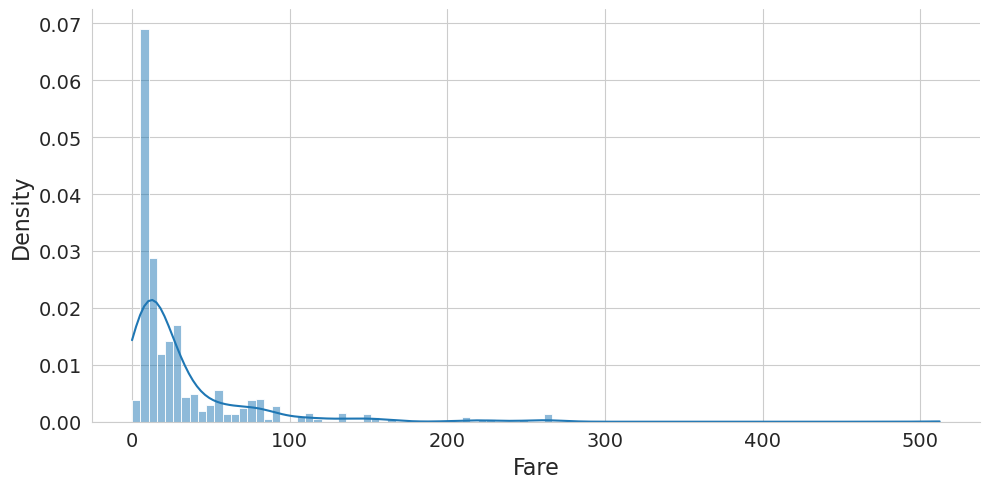

In [80]:
sns.displot(data=exploratory_set, x='Fare', stat='density', aspect=2, kde=True)
# plt.savefig('../docs/images/fare_distribution.pdf', bbox_inches='tight')
plt.show()

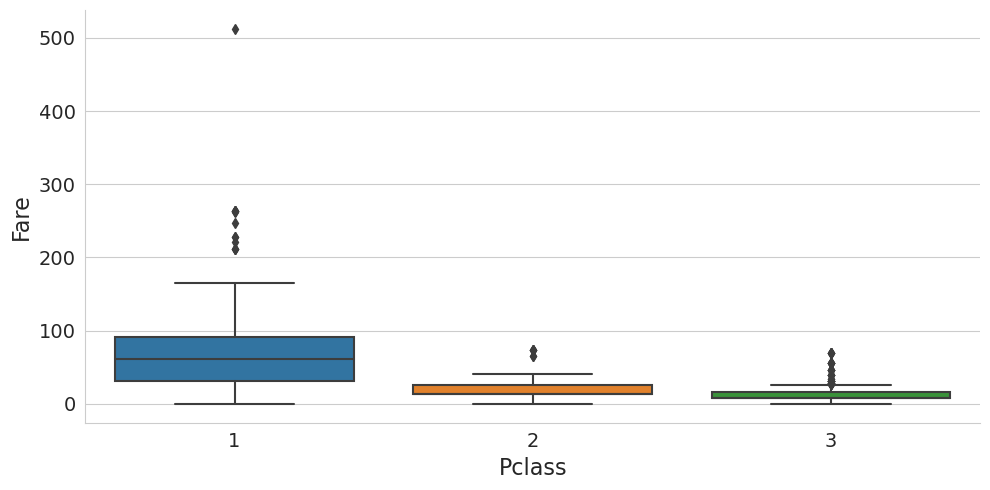

In [81]:
sns.catplot(data=exploratory_set, y='Fare', x='Pclass', aspect=2, kind='box')
# plt.savefig('../docs/images/fare_distribution_by_pclass.pdf', bbox_inches='tight')
plt.show()

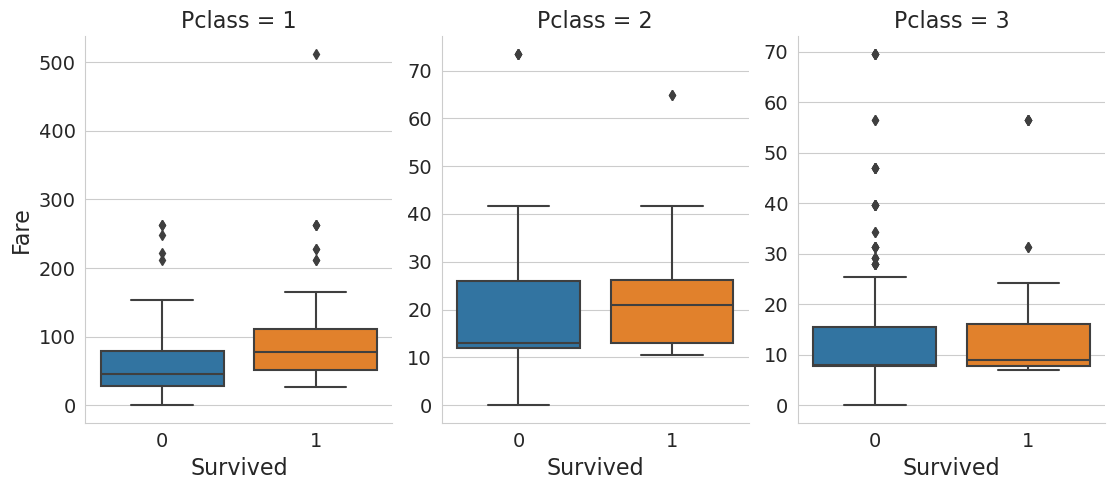

In [82]:
sns.catplot(data=exploratory_set, y='Fare', x='Survived', col='Pclass', sharey=False, kind='box', aspect=0.75)
# plt.savefig('../docs/images/fare_distribution_by_pclass_and_survived.pdf', bbox_inches='tight')
plt.show()

### Cabin

In [83]:
exploratory_set.Cabin.head()

788    NaN
347    NaN
629    NaN
734    NaN
106    NaN
Name: Cabin, dtype: object

In [84]:
exploratory_set.Cabin.info()

<class 'pandas.core.series.Series'>
Int64Index: 712 entries, 788 to 261
Series name: Cabin
Non-Null Count  Dtype 
--------------  ----- 
164 non-null    object
dtypes: object(1)
memory usage: 27.3+ KB


In [85]:
exploratory_set.Cabin.describe()

count             164
unique            128
top       C23 C25 C27
freq                4
Name: Cabin, dtype: object

In [86]:
exploratory_set.Cabin.nunique()

128

In [87]:
exploratory_set.Cabin.value_counts(dropna=False)

NaN            548
C23 C25 C27      4
G6               3
B22              2
E24              2
              ... 
E38              1
B78              1
D46              1
C126             1
B94              1
Name: Cabin, Length: 129, dtype: int64

### Embarked

In [88]:
exploratory_set.Embarked.head()

788    S
347    S
629    Q
734    S
106    S
Name: Embarked, dtype: object

In [89]:
exploratory_set.Embarked.info()

<class 'pandas.core.series.Series'>
Int64Index: 712 entries, 788 to 261
Series name: Embarked
Non-Null Count  Dtype 
--------------  ----- 
710 non-null    object
dtypes: object(1)
memory usage: 27.3+ KB


In [90]:
exploratory_set.Embarked.describe()

count     710
unique      3
top         S
freq      515
Name: Embarked, dtype: object

In [91]:
exploratory_set.Embarked.value_counts(dropna=False)

S      515
C      132
Q       63
NaN      2
Name: Embarked, dtype: int64

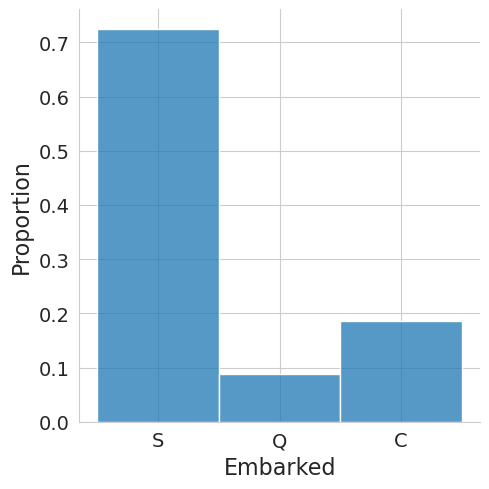

In [92]:
sns.displot(data=exploratory_set, x='Embarked', stat='proportion')
# plt.savefig('../docs/images/embarked_distribution.pdf', bbox_inches='tight')
plt.show()

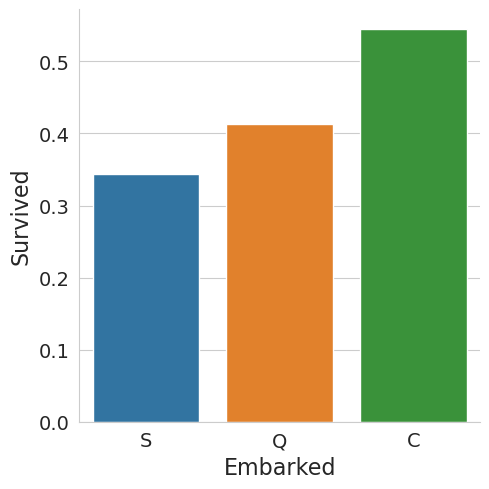

In [93]:
sns.catplot(data=exploratory_set, x='Embarked', y='Survived', kind='bar', errorbar=None)
# plt.savefig('../docs/images/embarked_survival_rate.pdf', bbox_inches='tight')
plt.show()

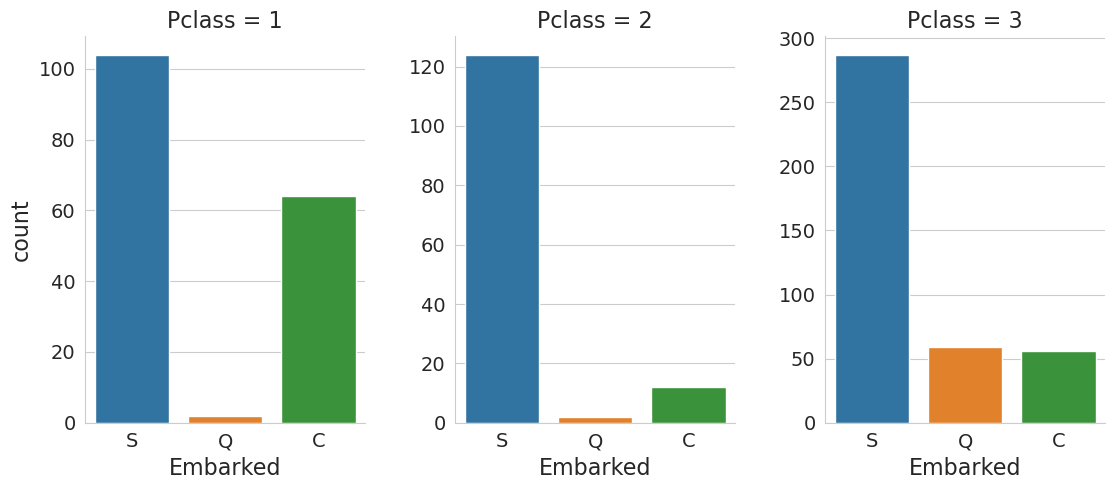

In [94]:
sns.catplot(data=exploratory_set, x='Embarked', col='Pclass', kind='count', sharey=False, aspect=0.75)
# plt.savefig('../docs/images/embarked_survival_rate_by_pclass.pdf', bbox_inches='tight')
plt.show()

### Correlation

In [95]:
exploratory_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 788 to 261
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  712 non-null    int64   
 1   Survived     712 non-null    int64   
 2   Pclass       712 non-null    category
 3   Name         712 non-null    object  
 4   Sex          712 non-null    object  
 5   Age          578 non-null    float64 
 6   SibSp        712 non-null    int64   
 7   Parch        712 non-null    int64   
 8   Ticket       712 non-null    object  
 9   Fare         712 non-null    float64 
 10  Cabin        164 non-null    object  
 11  Embarked     710 non-null    object  
 12  Title        712 non-null    object  
dtypes: category(1), float64(2), int64(4), object(6)
memory usage: 89.3+ KB


In [96]:
exploratory_set.Pclass = exploratory_set.Pclass.astype(np.int64)
exploratory_set.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.040851,0.007666,0.013094,-0.060270,0.008112,-0.018438
Survived,-0.040851,1.000000,-0.314577,-0.075542,-0.045019,0.059276,0.248255
Pclass,0.007666,-0.314577,1.000000,-0.410414,0.088154,0.023130,-0.581269
Age,0.013094,-0.075542,-0.410414,1.000000,-0.326746,-0.184323,0.132593
SibSp,-0.060270,-0.045019,0.088154,-0.326746,1.000000,0.417455,0.187942
Parch,0.008112,0.059276,0.023130,-0.184323,0.417455,1.000000,0.258895
Fare,-0.018438,0.248255,-0.581269,0.132593,0.187942,0.258895,1.000000


In [97]:
def plot_diag_cor_matrix(data):
    corr = data.corr()
    
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    f, ax = plt.subplots(figsize=(10, 10))
    
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    
    sns.heatmap(corr, 
                mask=mask, 
                cmap=cmap, 
                annot=True,
                vmax=0.6,
                vmin=-0.6,
                center=0, 
                square=True, 
                linewidths=3,
                cbar_kws={"shrink": .5},
                annot_kws={"fontsize": 14}
               )
    
    ax.set_title('Correlation coefficient')
    
    return f, ax

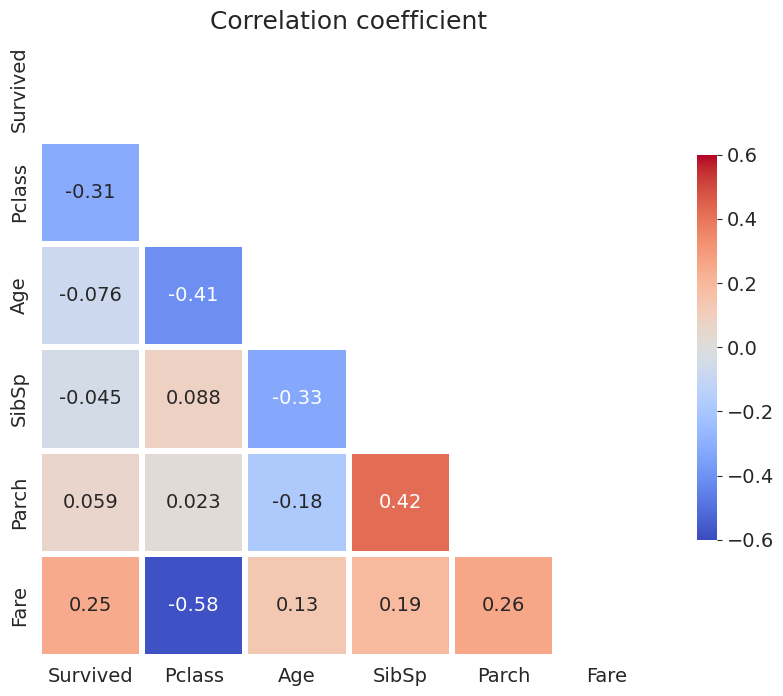

In [98]:
f, ax = plot_diag_cor_matrix(exploratory_set.drop(columns='PassengerId'))
# plt.savefig('../docs/images/diag_cor_matrix_0.pdf', bbox_inches='tight')
plt.show()

## Data Preparation

### Copy a clean training set

In [99]:
X_train = train_set.drop(columns='Survived')
y_train = train_set.Survived.copy()

### Data Cleaning

In [100]:
pd.concat([X_train, y_train], axis=1).head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
788,789,3,"Dean, Master. Bertram Vere",male,1.0,1,2,C.A. 2315,20.5750,NaN,S,1
347,348,3,"Davison, Mrs. Thomas Henry (Mary E Finck)",female,NaN,1,0,386525,16.1000,NaN,S,1
629,630,3,"O'Connell, Mr. Patrick D",male,NaN,0,0,334912,7.7333,NaN,Q,0
734,735,2,"Troupiansky, Mr. Moses Aaron",male,23.0,0,0,233639,13.0000,NaN,S,0
106,107,3,"Salkjelsvik, Miss. Anna Kristine",female,21.0,0,0,343120,7.6500,NaN,S,1


In [101]:
pd.concat([X_train, y_train], axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 788 to 261
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Pclass       712 non-null    int64  
 2   Name         712 non-null    object 
 3   Sex          712 non-null    object 
 4   Age          578 non-null    float64
 5   SibSp        712 non-null    int64  
 6   Parch        712 non-null    int64  
 7   Ticket       712 non-null    object 
 8   Fare         712 non-null    float64
 9   Cabin        164 non-null    object 
 10  Embarked     710 non-null    object 
 11  Survived     712 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 88.5+ KB


In [102]:
pd.concat([X_train, y_train], axis=1).isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            134
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          548
Embarked         2
Survived         0
dtype: int64

In [103]:
imputer = DataFrameMapper([
    (['Age'], SimpleImputer(strategy='median')),
    (['Cabin'], MissingIndicator()),
], default=None, df_out=True)

In [104]:
imputer.fit_transform(X_train).head()

,Age,Cabin,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Embarked
788,1.0,True,789,3,"Dean, Master. Bertram Vere",male,1,2,C.A. 2315,20.575,S
347,28.0,True,348,3,"Davison, Mrs. Thomas Henry (Mary E Finck)",female,1,0,386525,16.1,S
629,28.0,True,630,3,"O'Connell, Mr. Patrick D",male,0,0,334912,7.7333,Q
734,23.0,True,735,2,"Troupiansky, Mr. Moses Aaron",male,0,0,233639,13.0,S
106,21.0,True,107,3,"Salkjelsvik, Miss. Anna Kristine",female,0,0,343120,7.65,S


### Feature Selection

In [105]:
selector = DataFrameMapper([], drop_cols=['PassengerId', 'Ticket'], default=None, df_out=True)

In [106]:
data_prep = Pipeline([
    ('imputer', imputer),
    ('selector', selector)
])

In [107]:
data_prep.fit_transform(X_train).head()

,Age,Cabin,Pclass,Name,Sex,SibSp,Parch,Fare,Embarked
788,1.0,True,3,"Dean, Master. Bertram Vere",male,1,2,20.575,S
347,28.0,True,3,"Davison, Mrs. Thomas Henry (Mary E Finck)",female,1,0,16.1,S
629,28.0,True,3,"O'Connell, Mr. Patrick D",male,0,0,7.7333,Q
734,23.0,True,2,"Troupiansky, Mr. Moses Aaron",male,0,0,13.0,S
106,21.0,True,3,"Salkjelsvik, Miss. Anna Kristine",female,0,0,7.65,S


### Feature engineering

In [ ]:
# exploratory_set['Title'] = exploratory_set.Name.str.extract(pat=r'\b,\s(.+)\.\s[\b(]?', expand=True)
# exploratory_set['Title'] = exploratory_set['Title'].str.lower()

### Discretization of the Age attribure

In [ ]:
# exploratory_set['AgeGroup'] = pd.cut(exploratory_set.Age, 5, labels=list(range(5)))
# exploratory_set.AgeGroup.head()
# exploratory_set.AgeGroup.info()
# exploratory_set.AgeGroup.describe()
# exploratory_set.AgeGroup.value_counts()
# exploratory_set.AgeGroup.hist()
# plt.show()
# exploratory_set.AgeGroup = exploratory_set.AgeGroup.astype('float')
# sns.catplot(data=exploratory_set, x='AgeGroup', y='Survived', kind='bar', errorbar=None)
# plt.show()
# sns.catplot(data=exploratory_set, x='AgeGroup', y='Survived', col='Sex', kind='bar', errorbar=None)
# plt.show()

https://ru.wikipedia.org/wiki/%D0%A2%D0%B8%D1%82%D0%B0%D0%BD%D0%B8%D0%BA

https://www.tensorflow.org/datasets/catalog/titanic

https://habr.com/ru/company/mlclass/blog/270973/

https://towardsdatascience.com/machine-learning-with-the-titanic-dataset-7f6909e58280

https://ru.wikipedia.org/wiki/%D0%9F%D0%B0%D1%81%D1%81%D0%B0%D0%B6%D0%B8%D1%80%D1%8B_%C2%AB%D0%A2%D0%B8%D1%82%D0%B0%D0%BD%D0%B8%D0%BA%D0%B0%C2%BB

https://www.openml.org/search?type=data&sort=runs&id=40945&status=active